In [46]:
import os        # to work with folder
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns   #nicer plots (like confusion matrix)

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import EfficientNetB0,MobileNetV2 
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score
import tensorflow.keras.backend as k

ImageDataGenerator → loads images from folders, applies augmentation

load_img → load a single image

EfficientNetB0, MobileNetV2 → ready-made pretrained CNN models

Dense → normal (fully connected) layer

GlobalAveragePooling2D → reduces CNN feature maps into one vector

Dropout → helps prevent overfitting by ignoring some neurons during training

Model → create the complete network

Adam → optimizer (controls learning speed)

EarlyStopping → stop training early if accuracy stops improving

These help us evaluate results: confusion matrix, precision, recall, F1 score.

K.clear_session() → clears memory from any old models.

In [48]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 validation_split=0.2)
training_set=train_datagen.flow_from_directory('Medicinal Leaf dataset',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical',
                                               subset='training')

Found 643 images belonging to 9 classes.


rescale=1./255
👉 Images have pixel values from 0 to 255.
👉 We divide them by 255 → now values are between 0 and 1.
👉 This makes training faster and more stable.

shear_range=0.2
👉 Randomly tilts the image (like slanting it).
👉 Helps the model learn different angles of the same leaf.

zoom_range=0.2
👉 Randomly zooms in/out on images.
👉 So the model doesn’t get confused if the leaf is close or far in a picture.

horizontal_flip=True
👉 Randomly flips the image left ↔ right.
👉 Because a leaf might face either direction in real life.

validation_split=0.2
👉 Splits dataset into:

80% training (model learns)
20% validation (model gets tested during training)
----------------------------------------------------------------------------------------------
target_size=(224,224)
👉 Every image will be resized to 224×224 pixels (because deep learning models require fixed size).

batch_size=32
👉 Instead of loading all images at once, load 32 images at a time (saves memory).

class_mode='categorical'
👉 Multi-class classification (since you have more than 2 plant classes).
👉 The output labels will be one-hot encoded (like [1,0,0] for Neem, [0,1,0] for Tulsi, etc.).

subset='training'
👉 From the dataset, take the 80% training portion (because earlier we set validation_split=0.2).

In [49]:
test_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
validation_generator=test_datagen.flow_from_directory('Medicinal Leaf dataset',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      subset='validation',
                                                      shuffle=False)

Found 155 images belonging to 9 classes.


ubset='validation'

Means “from the dataset, use the 20% reserved for validation.”
⚠️ But this only works if you set validation_split=0.2 when you created the generator (you didn’t in this snippet).

shuffle=False

Do not shuffle validation images.
This way, the order of predictions matches the order of true labels.
Useful for evaluation (confusion matrix, classification report).

Without Validation Data

If you train without validation_generator, you’ll only see training accuracy, but you won’t know how well your model is performing on unseen data.
That’s risky ⚠️ → you might think your model is “perfect” (99% accuracy) but it actually fails on real new images.


0% of images → used for training (subset='training').
20% of images → used for validation (subset='validation').
So this validation_generator gives you access to that 20% part.

Pretrained Model

In [50]:
base_model_choice='MobileNet'
if base_model_choice == 'MobileNet':
    base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
else:
    base_model=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3))

base_model_choice is the pretrained layer

Add classification Layer

In [51]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.4)(x)
predictions=Dense(training_set.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

Why pooling is used?
Pooling is a way to reduce the size of feature maps (the outputs of convolutional layers) while keeping the important information.

Think of it like:
You have a big detailed photo 🖼️.
Pooling is like making a summary version of that photo that still shows the main things but is smaller and easier to handle.

predictions = Dense(train_generator.num_classes, activation='softmax')(x)

Dense(...) → this creates the final output layer of your neural network.

train_generator.num_classes → tells how many classes are in your dataset (for example, 10 medicinal plants).

activation='softmax' → converts the output into probabilities (so the sum = 1).(For multiclass classification)

(x) → connects this new layer to the features coming from the previous layers.

👉 So this line means:
“Add a final classification layer that outputs one probability for each plant class.”

Line 2:

model = Model(inputs=base_model.input, outputs=predictions)
Model(...) → creates the full model.

inputs=base_model.input → use the original pretrained CNN’s input (the image that goes in).

outputs=predictions → use our new classification layer as the output (the probabilities).

👉 So this line means:
“Build the complete model: take an image as input → pass through the pretrained CNN → then through GAP + Dropout → then output probabilities for each class.”

✅ In short:

First line = create the output layer.
Second line = connect everything together into one model.

Do you want me to draw a simple block diagram (Input → Base Model → GAP → Dropout → Dense → Output) so you can visualize this better?

In [52]:
for layers in base_model.layers:
    layers.trainable=False

Imagine this:

You have a student (the base model: MobileNet/EfficientNet).
This student already went to school for many years and learned a lot about shapes, colors, patterns, etc. (that’s ImageNet training).

Now you want this student to learn about plants 🌱.

Step 1: Lock old knowledge
for layer in base_model.layers:
    layer.trainable = False


This means:
👉 "Don’t erase what you already learned in school. Just keep that knowledge safe."

So the student doesn’t change old knowledge.
Instead, you only teach them a new final lesson (your last few layers that classify plant diseases).

Training the CNN

Compiling the CNN

In [53]:
model.compile(optimizer=Adam(learning_rate=3e-4),loss='categorical_crossentropy',metrics=['accuracy'])

Fine-tuning means-  why learning rate is used?
“Keep the general knowledge, but slightly adjust the model’s last part so it becomes an expert in my specific dataset.”

Early Stopping

In [54]:
early_stop=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

monitor='val_accuracy' → Watch the validation accuracy (how well the model performs on unseen data).

patience=5 → If validation accuracy doesn’t improve for 5 epochs in a row, stop training.

restore_best_weights=True → After stopping, go back to the model state where it had the best validation accuracy (not the last one).

Suppose you planned for 50 epochs.

By epoch 20, validation accuracy = 85% (best).

From epoch 21 to 25, accuracy doesn’t improve (still ~84–85%).

At epoch 25 → patience (5 epochs) is over → training stops automatically.

Model goes back to the weights from epoch 20 (best point).

Training the CNN on the Training set and evaluating it on the Test set

In [55]:
model.fit(training_set,validation_data=validation_generator,epochs=10,callbacks=[early_stop])

c:\Users\iemss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.2167 - loss: 2.3324 - val_accuracy: 0.2903 - val_loss: 1.8887
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3615 - loss: 1.8112 - val_accuracy: 0.4645 - val_loss: 1.5338
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5196 - loss: 1.3652 - val_accuracy: 0.5613 - val_loss: 1.3190
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6023 - loss: 1.1761 - val_accuracy: 0.6194 - val_loss: 1.1553
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6451 - loss: 1.0443 - val_accuracy: 0.6774 - val_loss: 1.0301
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7077 - loss: 0.9636 - val_accuracy: 0.7032 - val_loss: 0.9400
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7879 - loss: 0.7037 - val_accuracy: 0.7161 - val_loss: 0.8692
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7571 - loss: 0.7233 - val_accuracy: 0.7419 - val_loss:

For fine tuning

In [56]:
for layers in base_model.layers[-30: ]:
    layers.trainable=True

Step 2: Unlock a little later
for layer in base_model.layers[-30:]:
    layer.trainable = True


After the student has learned the basics of your new topic (plants), you allow them to adjust some of their old knowledge (according to last few layers).
This way, they can fine-tune what they knew before to match your new subject better.

✅ Super short:

Freeze layers = Don’t change old knowledge.
Unfreeze later = Let the model slightly adjust its old knowledge to your new dataset.

In [57]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [58]:
history=model.fit(training_set,validation_data=validation_generator,epochs=20,callbacks=[early_stop])

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7204 - loss: 0.8213 - val_accuracy: 0.7806 - val_loss: 0.6967
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7478 - loss: 0.7894 - val_accuracy: 0.7742 - val_loss: 0.6736
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8067 - loss: 0.6161 - val_accuracy: 0.7806 - val_loss: 0.6538
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8713 - loss: 0.5355 - val_accuracy: 0.7871 - val_loss: 0.6358
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8838 - loss: 0.4888 - val_accuracy: 0.7935 - val_loss: 0.6155
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8845 - loss: 0.4470 - val_accuracy: 0.7935 - val_loss: 0.5963
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9044 - loss: 0.4112 - val_accuracy: 0.7871 - val_loss: 0.5836
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9353 - loss: 0.3342 - val_accuracy: 0.8000 - val_loss:

To save model

In [59]:
model.save('my_model.keras')
print("Model saved as 'my_model.keras'")

Model saved as 'my_model.keras'


To know y_pred,y_true

In [60]:
validation_generator.reset()
predicted=model.predict(validation_generator,verbose=1)
y_pred=np.argmax(predicted,axis=1)
y_true=validation_generator.classes
class_labels=list(validation_generator.class_indices.keys())

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 


val_generator.reset()
👉 This makes sure the validation generator starts from the beginning of the dataset.
(Important because sometimes the generator remembers its last position.)
------------------------------------------------
preds = model.predict(val_generator, verbose=1)
👉 The model makes predictions on all validation images.

preds will be a 2D array of probabilities.
Example (for 3 classes):

[[0.1, 0.8, 0.1],
 [0.7, 0.2, 0.1], ...]

----------------------------------------------------------
y_pred = np.argmax(preds, axis=1)
👉 Converts probabilities into predicted class labels.

argmax picks the index of the highest probability.
Example:
[0.1, 0.8, 0.1] → class 1
[0.7, 0.2, 0.1] → class 0

argmax means: pick the index (position) of the biggest number.
For Image 1 → biggest is 0.8 at position 1 → class 1 (Dog)
For Image 2 → biggest is 0.7 at position 0 → class 0 (Cat)

--------------------------------------------------------------
y_true = val_generator.classes
👉 Gets the true labels (actual class numbers) from the validation dataset.
Example: [0, 1, 2, 0, 1, ...]

-------------------------------------------------------------------------
class_labels = list(val_generator.class_indices.keys())
👉 Gets the class names (like "Healthy", "Diseased", etc.).
So you can print reports with names instead of just number 

Why is this useful?

Without class labels, the model would only tell you:
True: 0  Predicted: 2
But with class_labels, you can print it in a readable way:
True: Healthy   Predicted: Late_Blight

In [61]:
print("classification_report")
print(classification_report(y_true,y_pred,target_names=class_labels))

classification_report
              precision    recall  f1-score   support

    Aloevera       0.78      0.78      0.78        23
        Amla       0.89      0.62      0.73        13
Amruthaballi       0.93      0.72      0.81        18
       Arali       0.77      1.00      0.87        17
      Thumbe       0.82      0.64      0.72        14
      Tomato       1.00      1.00      1.00        12
       Tulsi       0.76      0.83      0.79        35
    Turmeric       0.88      1.00      0.93         7
      ashoka       0.89      1.00      0.94        16

    accuracy                           0.83       155
   macro avg       0.86      0.84      0.84       155
weighted avg       0.84      0.83      0.83       155



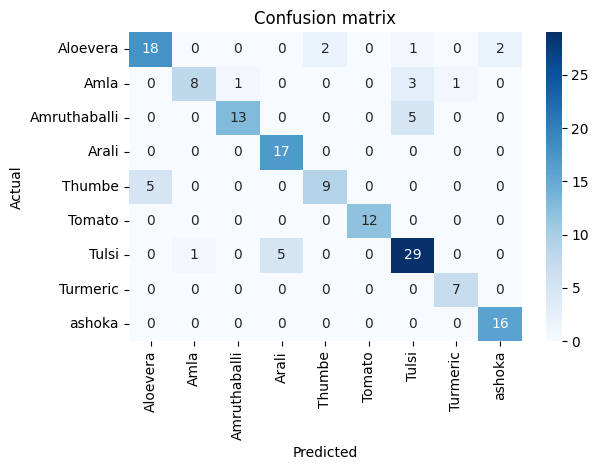

In [62]:
cm=confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()

annot=True

Means show the numbers inside each square.
Without this, you’d just see colors, no counts.

🔹 3. fmt='d'

Formatting of the numbers.
'd' means integer format (whole numbers).
(Because confusion matrix values are counts, not decimals.)

🔹 4. xticklabels=class_labels and yticklabels=class_labels

These set the axis labels to your class names.
X-axis = Predicted classes
Y-axis = Actual (true) classes

So instead of seeing 0,1,2, you’ll see:

X-axis → ['Healthy', 'Early_Blight', 'Late_Blight']
Y-axis → ['Healthy', 'Early_Blight', 'Late_Blight']

🔹 5. cmap='Blues'

Chooses the color theme for the heatmap.
Blues means lighter blue = small number, darker blue = bigger number.
------------------------------------------------------------------------------

plt.tight_layout() tells Matplotlib to automatically adjust the spacing between plots, titles, labels, and ticks so that nothing overlaps or gets cut off.

Plotting of Training accuracy vs Validation accuracy

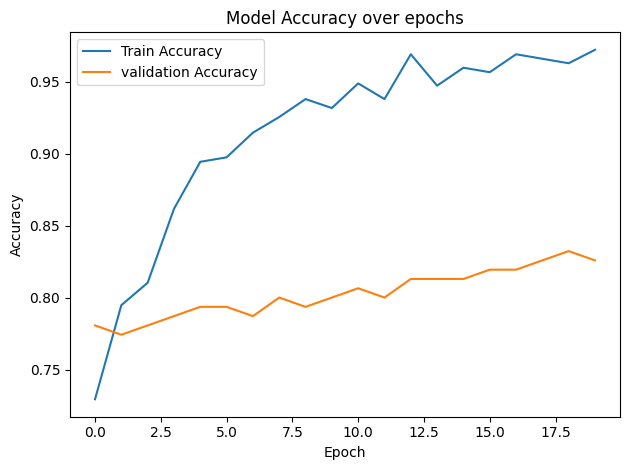

In [63]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='validation Accuracy')
plt.title('Model Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

What this graph shows

Training accuracy (blue) goes up quickly →
The model is learning patterns from the training data and fitting them well.
It reaches ~0.96 (96%), which is very high.

Validation accuracy (orange) also goes up but much slower →
It increases to ~0.86 (86%) and then stays relatively stable.

Gap between train and validation accuracy →
The model performs much better on training data than validation data.
This usually means overfitting: the model is memorizing training data more than generalizing to new data.

In [64]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1_score = f1_score(y_true, y_pred, average='weighted')
print("Overall Metrics (weighted_avg)")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

Overall Metrics (weighted_avg)
Precision: 0.838183863862981
Recall: 0.832258064516129
F1-Score: 0.8282608665541005


1. precision

👉 When the model says “Diseased”, how often is it correct?

Example:

Model predicts 20 leaves as Diseased.
15 of them are really Diseased ✅
5 are actually Healthy ❌
Precision = 15 / 20 = 75%

2. Recall

👉 Out of all the real Diseased leaves, how many did the model find?

Example:

There are 30 Diseased leaves in reality.
Model correctly finds 15 of them ✅
Misses 15 ❌
Recall = 15 / 30 = 50%

3. F1-score

👉 Just a balance between Precision and Recall.

If both are high → F1 is high.
If one is low → F1 goes down.
In the above example:
Precision = 75%, Recall = 50% → F1 ≈ 60%
----------------------------------------------------------------------------------------
Why we use weighted in precision/recall/F1?

👉 Because in your plant dataset, some classes have many more images than others.

Example 🌱:

Healthy leaves → 800 images
Early Blight → 150 images
Late Blight → 50 images

If we don’t use weighted, then each class is treated equally, even though Healthy has way more images.
That means a small class (like Late Blight with only 50 images) could affect the final score too much.

Display Misclassified Images

In [65]:
filenames=validation_generator.filenames
misclassified_indices=np.where(y_pred!=y_true)[0]#
print("Misclassified Images:",len(misclassified_indices))

Misclassified Images: 26


misclassified_indices = np.where(y_pred != y_true)[0]

👉 This finds the positions (indexes) of images that the model got wrong.

y_true = actual class numbers (e.g., Healthy=0, Early_Blight=1, Late_Blight=2)
y_pred = model’s predicted class numbers
If they are not equal → misclassified.

Example:

y_true = [0, 1, 2, 0]
y_pred = [0, 2, 2, 1]
Misclassified at indexes 1 and 3.
So misclassified_indices = [1, 3]

To show the result

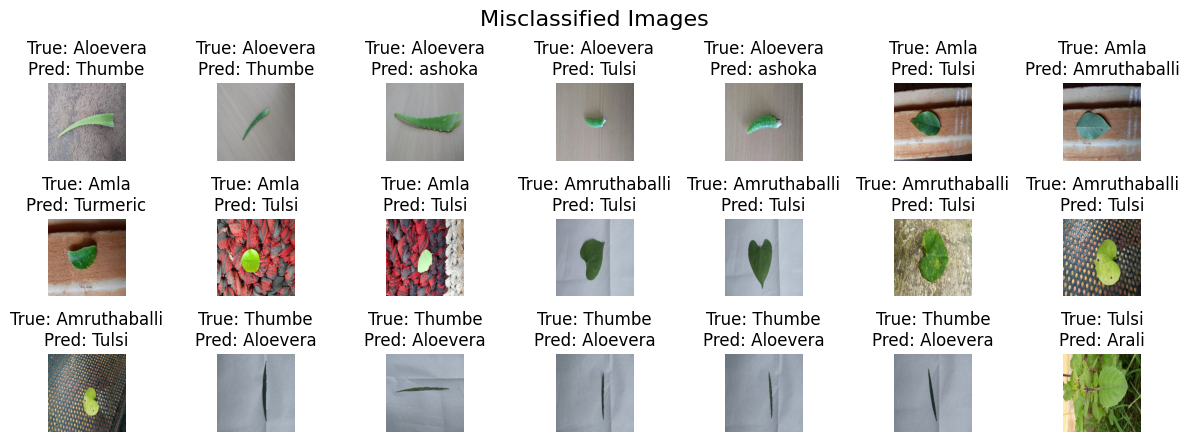

In [66]:
num_misclassified = min(21, len(misclassified_indices))
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_indices[:num_misclassified]):
    img_path = os.path.join("D:/Medicinal Plant Detection/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset", filenames[idx])
    img = load_img(img_path, target_size=(224,224))
    plt.subplot(7, 7, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
plt.suptitle("Misclassified Images", fontsize=16)
plt.tight_layout()
plt.show()


num_misclassified = min(21, len(misclassified_indices))

Choose how many misclassified images to show.
len(misclassified_indices) is the total number of wrong images; min(21, ...) picks the smaller of 21 and that total so you don’t try to plot more than you have.

plt.figure(figsize=(12, 10))

Create a new matplotlib figure (canvas) to draw on.
figsize=(12,10) sets the width and height (in inches) so images are large enough to see.


for i, idx in enumerate(misclassified_indices[:num_misclassified]):

Loop over the first num_misclassified misclassified image indexes.
enumerate(...) gives two values each loop:
i = loop counter (0, 1, 2, ...), used for subplot placement.
idx = the actual index into the validation set / filenames list for that misclassified image.


img_path = os.path.join("D:/Medicinal Plant Detection/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset", filenames[idx])

Build the full file path to the image by joining the dataset folder path and the filename at position idx.
filenames[idx] is something like 'Late_Blight/leaf123.jpg'; os.path.join combines them into a platform-correct path.


img = load_img(img_path, target_size=(224,224))

Load the image from disk and resize it to 224×224 pixels (so it matches model input / display size).
load_img returns a PIL image object that plt.imshow can display.


plt.subplot(7, 7, i + 1)

Create/select the subplot (small cell) where this image will be drawn.
subplot(7, 7, i+1) arranges subplots in a 7×7 grid and picks the (i+1)-th cell.
(You only fill up to num_misclassified cells; the rest stay empty.)


plt.imshow(img)

Show the loaded image inside the current subplot.


plt.axis('off')

Turn off the axis ticks/labels so the image looks clean (no x/y numbers).


plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")

Put a small title above the image with the true label and the predicted label.
\n makes a newline so Pred appears on the second line.
class_labels[...] converts class indices into readable names like "Healthy".


plt.suptitle("Misclassified Images", fontsize=16)\

Add one big title for the whole figure (shown above all subplots).


plt.tight_layout()

Auto-adjust subplot spacing so titles and images don’t overlap.


plt.show()

Render and display the figure with all the plotted misclassified images.

In [67]:
filenames=validation_generator.filenames
classified_indices=np.where(y_pred==y_true)[0]#
print("classified Images:",len(classified_indices))

classified Images: 129


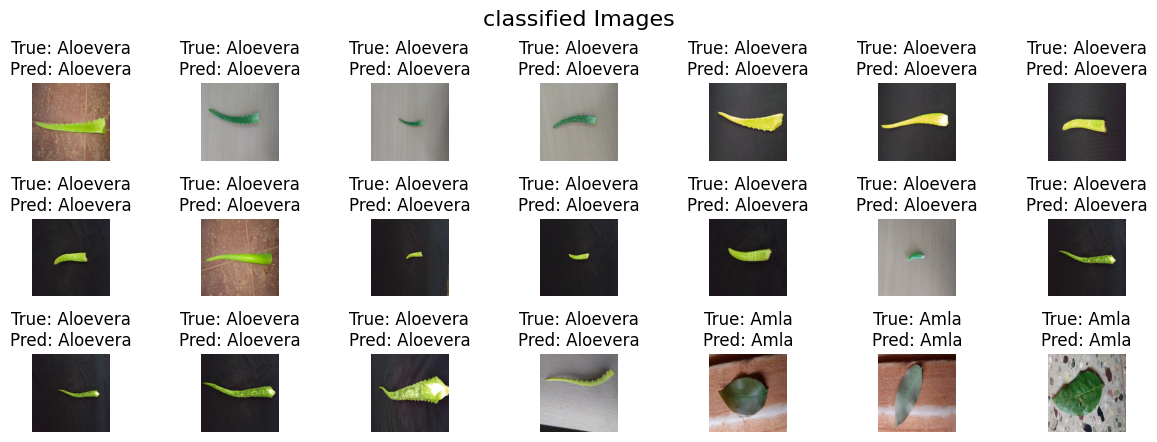

In [68]:
num_classified = min(21, len(classified_indices))
plt.figure(figsize=(12, 10))
for i, idx in enumerate(classified_indices[:num_classified]):
    img_path = os.path.join("D:/Medicinal Plant Detection/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset", filenames[idx])
    img = load_img(img_path, target_size=(224,224))
    plt.subplot(7, 7, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
plt.suptitle("classified Images", fontsize=16)
plt.tight_layout()
plt.show()